# Ordinal analysis of the MTurk Experiment

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import norm
from scipy.stats import t as studentT
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from IPython.display import Image
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline
plt.style.use('seaborn-white')

# sb.set_context(
#     "talk",
#     font_scale=1,
#     rc={
#         "lines.linewidth": 2.5,
#         "text.usetex": True,
#         "font.family": 'serif',
#         "font.serif": 'Palatino',
#         "font.size": 16
#     })
# from matplotlib import rc
# # rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 16})
# # ## for Palatino and other serif fonts use:
# # rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 16})

# font = {'family': 'serif', 'serif': 'Palatino', 'weight': 'bold', 'size': 16}
# rc('font', **font)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']

# rc('text', usetex=True)

# sb.set_context(
#     "talk",
#     font_scale=1,
#     rc={
#         "lines.linewidth": 2.5,
#         "text.usetex": True,
#         "font.family": 'sans-serif',
#         "font.serif": 'Helvetica',
#         "weight": 'bold',
#         "font.size": 12
#     })
# from matplotlib import rc
# # rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 16})
# # ## for Palatino and other serif fonts use:
# # rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 16})

# font = {'family': 'sans-serif', 'sans-serif': 'Helvetica', 'weight': 'bold', 'size': 12}
# rc('font', **font)
# rc('text', usetex=True)

/Users/harisundaram/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data

In [29]:
# Using dtype 'category' for Y
df = pd.read_csv(
    'data/all_item_output_926.csv',
    dtype={
        'y': 'int',
        'gesture': 'int',
        'dist': 'int',
        'shading': 'int',
        'cond': 'int',
        'comicleft': 'int'
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 6 columns):
gesture      655 non-null int64
dist         655 non-null int64
shading      655 non-null int64
y            655 non-null int64
cond         655 non-null int64
comicleft    655 non-null int64
dtypes: int64(6)
memory usage: 30.8 KB


In [30]:
# defining some temp variables for the least squares estimate.
X = df[['gesture', 'dist', 'shading', 'cond', 'comicleft']]
X_i = (X - X.mean())/X.std() # predictors
Y_r = (df['y'] + 4).values # to create a response variable
X_i['c'] = 1
X_i = X_i.reindex(columns=['c', 'gesture', 'dist', 'shading', 'cond', 'comicleft'])
[beta_test_val, residual, rank, eig] = np.linalg.lstsq(X_i, Y_r, rcond=None)

In [31]:
eig

array([27.00611789, 26.33067318, 25.59296778, 25.40641385, 24.83253889,
       24.19141158])

In [32]:
df['y'] = (df['y'] + 4).astype('category') # changing the range to 1-7
dfpos = df[df.cond==1]
dfneg = df[df.cond==0]

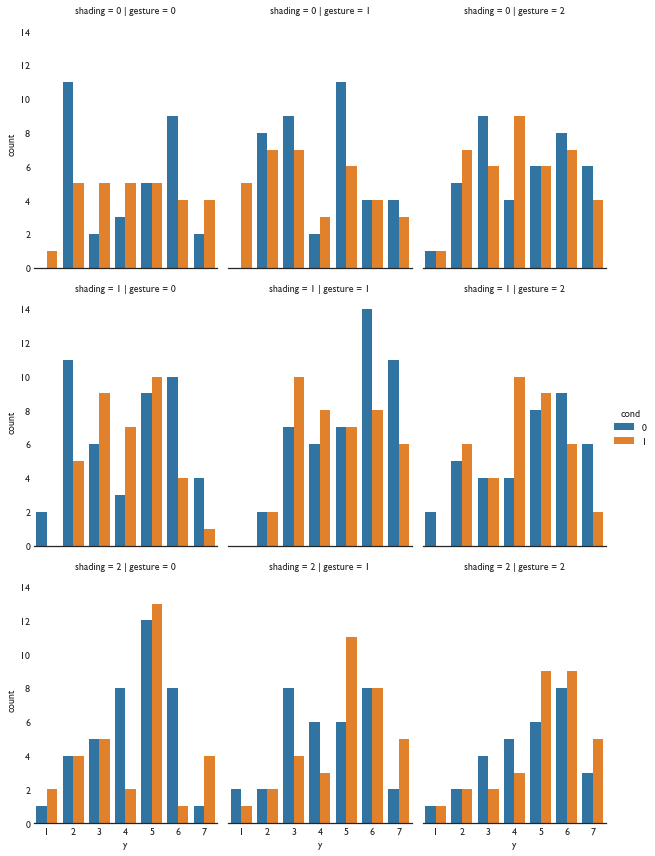

In [7]:
g = sb.factorplot(
    x="y",
    hue="cond",
    col="gesture",
    row="shading",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("condition-gesture-shading-counts.pdf")

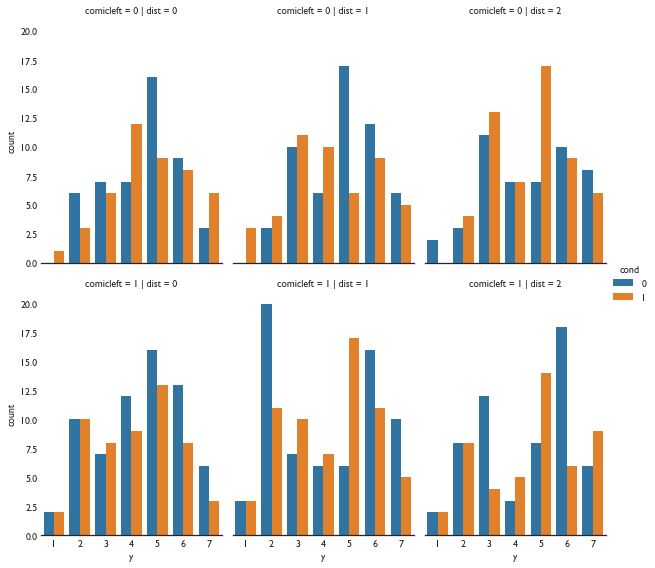

In [8]:
g = sb.factorplot(
    x="y",
    hue="cond",
    col="dist",
    row="comicleft",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("condition-dist-counts.pdf")

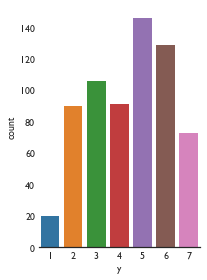

In [10]:
g = sb.factorplot(
    x="y",
    data=df,
    kind="count",
    size=4,
    aspect=0.7)
g.despine(left=True)
g.savefig("counts-main.pdf")

In [33]:

y_cat = (df['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

In [34]:
sd_X = X.std()
mean_X = X.mean()
zX = (X - mean_X)/sd_X
# zX = X # don't normalize because all values are between 0-2

In [35]:
nYlevels4 = y_cat.nunique()

thresh4 = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

pr_test_val = df.groupby('y').size()/df.shape[0]

thresh4:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs4:	[1.5 -- -- -- -- 6.5]


In [36]:
pr_test_val

y
1    0.030534
2    0.137405
3    0.161832
4    0.138931
5    0.222901
6    0.196947
7    0.111450
dtype: float64

In [43]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as ordinal_model_multi_metric:

    theta = pm.Normal(
        'theta',
        mu=thresh4,
        tau=np.repeat(1 / 2**2, len(thresh4)),
        shape=len(thresh4),
        observed=thresh_obs4,
        testval=thresh4)

    # all coefficients should center at 0.0 because outocme 'y' is symmetric [-3,3]
#     zbeta0 = pm.Normal('zbeta0', mu=(1 + nYlevels4) / 2, tau=1 / nYlevels4**2, testval=beta_test_val[0])
#     zbeta = pm.Normal('zbeta', mu=0.0, tau=1 / nYlevels4**2, shape=X.shape[1], testval=beta_test_val[[1, 2, 3, 4, 5]])
    zbeta0 = pm.Cauchy('zbeta0', alpha=(1 + nYlevels4) / 2, beta=nYlevels4**2, testval=beta_test_val[0])
    zbeta = pm.Cauchy('zbeta', alpha=0.0, beta=nYlevels4**2, shape=X.shape[1], testval=beta_test_val[[1, 2, 3, 4, 5]])
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, zX.T))
#     zsigma = pm.Uniform('zsigma', nYlevels4 / 1000.0, nYlevels4, testval=1.8)
    zsigma = pm.HalfCauchy('zsigma', beta=nYlevels4, testval=1.8)

    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical('Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [44]:
with ordinal_model_multi_metric:
    step1 = pm.Metropolis()
    trace4 = pm.sample(10000, step=step1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [zsigma_log__]
>Metropolis: [zbeta]
>Metropolis: [zbeta0]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [03:19<00:00, 52.69it/s]
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
trace4.

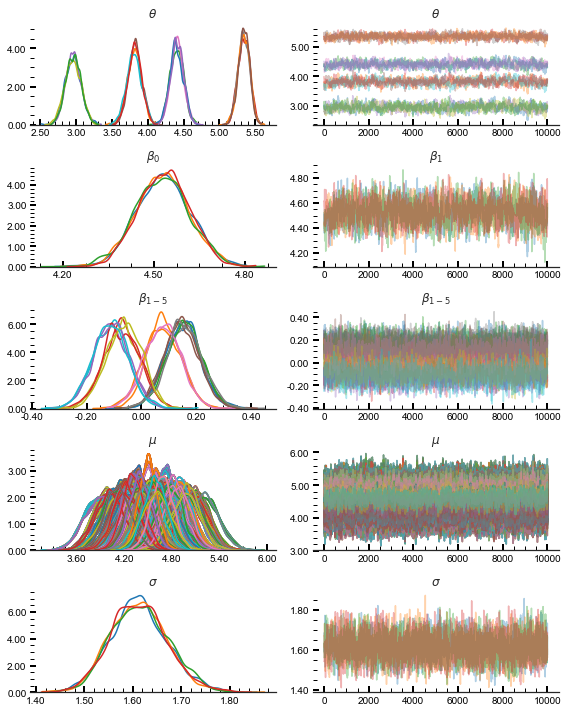

In [45]:
burned_trace = trace4 # pymc3.1 discards the first 500 samples
# pm.traceplot(burned_trace);

NRows = 5  # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(8, 10)
# fig, axs = sb.plt.subplots(5, 2) #### change on changing parameters
# fig.set_size_inches(12, 12)
pm.plots.traceplot(
    trace=burned_trace,
        varnames=['theta_missing', 'zbeta0', 'zbeta', 'mu', 'zsigma'],
    ax=axs)
axs[0, 0].set_title(r"$\theta$")
axs[0, 1].set_title(r"$\theta$")
axs[1, 0].set_title(r"$\beta_0$")
axs[1, 1].set_title(r"$\beta_1$")
axs[2, 0].set_title(r"$\beta_{1-5}$")
axs[2, 1].set_title(r"$\beta_{1-5}$")
axs[3, 0].set_title(r"$\mu$")
axs[3, 1].set_title(r"$\mu$")
axs[4, 0].set_title(r"$\sigma$")
axs[4, 1].set_title(r"$\sigma$")
axs[1, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[3, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[4, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("")  # no individual labels
        z.set_ylabel("")
        if j==0:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(
            direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(
            direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()
        
sb.despine(fig=fig, left=True)
fig.tight_layout()
fig.savefig("traceplots, main, Cauchy.pdf")

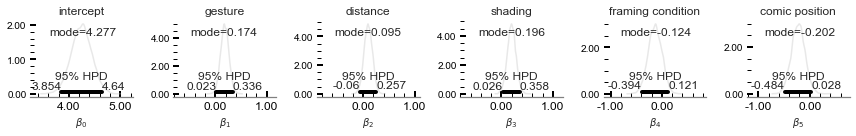

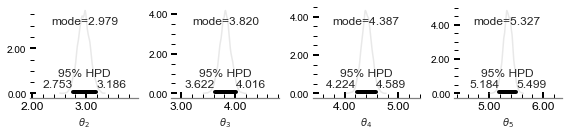

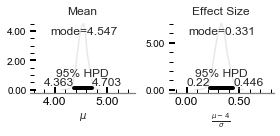

In [46]:
burnin = 500
# Convert parameters to original scale
beta = trace4['zbeta'] / sd_X.as_matrix()
beta0 = trace4['zbeta0'] - np.sum(
    trace4['zbeta'] * mean_X.as_matrix() / sd_X.as_matrix(), axis=1)
sigma = trace4['zsigma']

sigma = trace4['zsigma']
mu = trace4['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

NRows = 1  # change based on the number of parameters
NCols = 6
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    beta0,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[0],
    text_size=12)
pm.plot_posterior(
    beta[:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[1],
    text_size=12)
pm.plot_posterior(
    beta[:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[2],
    text_size=12)
pm.plot_posterior(
    beta[:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[3],
    text_size=12)
pm.plot_posterior(
    beta[:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[4],
    text_size=12)
pm.plot_posterior(
    beta[:, 4],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[5],
    text_size=12)

beta_vars = [
    'intercept', 'gesture', 'distance', 'shading', 'framing condition',
    'comic position'
]
for j in range(NCols):
    z = axs[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\beta_{{{0}}}$".format(j)
    z.set_xlabel(s)
    z.set_title("{0}".format(beta_vars[j]))
    if j==0:
        center = beta0.mean()
    else:
        center = beta[:,j-1].mean()
    z.set_xlim([center-1, center+1])  
    
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig.tight_layout()

fig.savefig("beta_values_main, cauchy.pdf")


# plot theta posterior

NRows = 1  # change based on the number of parameters
NCols = 4  # four interior values
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace4['theta_missing'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[0],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[1],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[2],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[3],
    text_size=12)

# beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs3[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\theta_{{{0}}}$".format(j+2)
    z.set_xlabel("{0}".format(s))
    center = trace4['theta_missing'][:, j].mean()
    z.set_xlim([center-1, center+1])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig3.tight_layout()

fig3.savefig("theta_values_main, cauchy.pdf")



fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r'Mean')
axs2[0].set_xlim([mu_mean.mean()-1,mu_mean.mean()+1])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([n_m.mean()-0.5, n_m.mean()+0.5])
axs2[1].set_xlabel(r'$\frac{\mu -4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect, posterior, main experiment, cauchy.pdf")

# for title, label, ax in zip(['Intercept', 'Year', 'Length'],
#                             [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
#                             [ax2, ax3, ax4]):
#     ax.set_title(title, fontdict=f_dict)
#     ax.set_xlabel(label, fontdict=f_dict)

# Color v. No Color

## data

In [32]:
# Using dtype 'category' for Y
df_color = pd.read_csv(
    'data/color_data_0330.csv',
    dtype={
        'y': 'int',
        'color': 'int',
        'color_position': 'int',
        'cond': 'int'
    })

In [33]:
df_color.columns = ['color', 'location', 'condition', 'y']

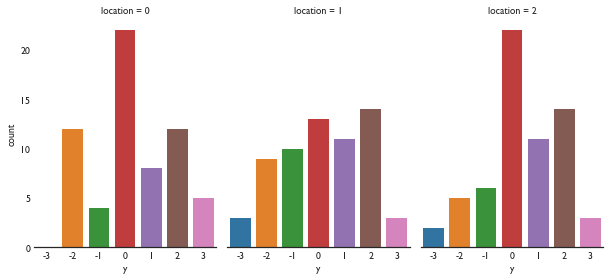

In [34]:
g_color = sb.factorplot(
    x="y",
#     hue="condition",
    col="location",
#     row="location",
    data=df_color,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)
g_color.savefig("effects_of_color.pdf")

## Bayesian analysis of color

In [35]:
X = df_color[['color', 'location', 'condition']]

# defining some temp variables for the least squares estimate.
X_i = (X - X.mean())/X.std() # predictors
Y_r = (df_color['y'] + 4).values # to create a response variable
X_i['c'] = 1
X_i = X_i.reindex(columns=['c', 'color', 'location', 'condition'])

df_color['y'] = (df_color['y'] + 4).astype(
    'category')  # changing the range to 1-7
y_cat = (df_color['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

In [38]:
[beta_test_val, residual, rank, eig] = np.linalg.lstsq(X_i, Y_r, rcond=None)

In [43]:
beta_test_val[[1,2,3]]

array([0.20993612, 0.05908573, 0.16207064])

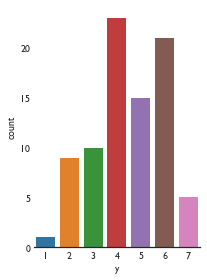

In [40]:
Pos = df_color[df_color.condition==1]
g_color = sb.factorplot(
    x="y",
    data=Pos,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)

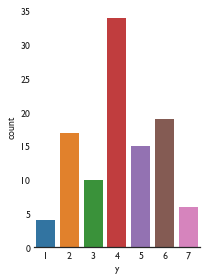

In [41]:
Neg = df_color[df_color.condition==0]
g_color = sb.factorplot(
    x="y",
    data=Neg,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)

In [40]:
sd_X = X.std()
mean_X = X.mean()
zX = (X - mean_X)/sd_X

In [41]:
nYlevels4 = y_cat.nunique()

thresh4 = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

#initial probabilities
pr_test_val = df_color.groupby('y').size()/df_color.shape[0]

thresh4:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs4:	[1.5 -- -- -- -- 6.5]


In [44]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as ordinal_model_color:

    theta = pm.Normal(
        'theta',
        mu=thresh4,
        tau=np.repeat(1 / 2**2, len(thresh4)),
        shape=len(thresh4),
        observed=thresh_obs4,
        testval=thresh4)

    # all coefficients should center at 0.0 because outocme 'y' is symmetric [-3,3]
    zbeta0 = pm.Normal('zbeta0', mu=(1 + nYlevels4) / 2, tau=1 / nYlevels4**2, testval=beta_test_val[0])
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1 / nYlevels4**2, shape=X.shape[1], testval=beta_test_val[[1, 2, 3]])
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, zX.T))
    zsigma = pm.Uniform('zsigma', nYlevels4 / 1000.0, nYlevels4, testval=1.5)

    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical('Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [46]:
with ordinal_model_color:
    step1 = pm.Metropolis()
    trace4 = pm.sample(10000, step=step1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [zsigma_interval__]
>Metropolis: [zbeta]
>Metropolis: [zbeta0]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [07:00<00:00, 24.95it/s]
The number of effective samples is smaller than 10% for some parameters.


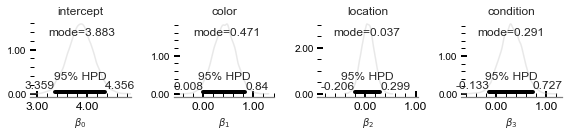

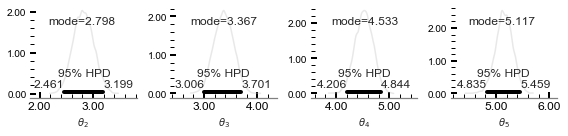

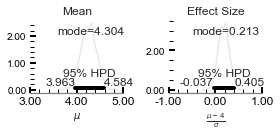

In [88]:
# Convert parameters to original scale
beta = trace4['zbeta'] / sd_X.as_matrix()
beta0 = trace4['zbeta0'] - np.sum(
    trace4['zbeta'] * mean_X.as_matrix() / sd_X.as_matrix(), axis=1)

sigma = trace4['zsigma']
mu = trace4['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

NRows = 1  # change based on the number of parameters
NCols = X.shape[1] + 1  # adding 1 for \beta_0
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    beta0,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[0],
    text_size=12)
pm.plot_posterior(
    beta[:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[1],
    text_size=12)
pm.plot_posterior(
    beta[:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[2],
    text_size=12)
pm.plot_posterior(
    beta[:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs[3],
    text_size=12)

beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\beta_{{{0}}}$".format(j)
    z.set_xlabel(s)
    z.set_title("{0}".format(beta_vars[j]))
    if j==0:
        center = beta0.mean()
    else:
        center = beta[:,j-1].mean()
    z.set_xlim([center-1, center+1])    
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig.tight_layout()

fig.savefig("beta_values_color.pdf")

# plot theta posterior

NRows = 1  # change based on the number of parameters
NCols = 4  # four interior values
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace4['theta_missing'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[0],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[1],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[2],
    text_size=12)
pm.plot_posterior(
    trace4['theta_missing'][:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[3],
    text_size=12)

# beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs3[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\theta_{{{0}}}$".format(j+2)
    z.set_xlabel("{0}".format(s))
    center = trace4['theta_missing'][:, j].mean()
    z.set_xlim([center-1, center+1])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig3.tight_layout()

fig3.savefig("theta_values_color.pdf")

# mean and mean effect size

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r"Mean")
axs2[0].set_xlim([3, 5])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([-1, 1])
axs2[1].set_xlabel(r'$\frac{\mu-4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect_color.pdf")

# for title, label, ax in zip(['Intercept', 'Year', 'Length'],
#                             [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
#                             [ax2, ax3, ax4]):
#     ax.set_title(title, fontdict=f_dict)
#     ax.set_xlabel(label, fontdict=f_dict)

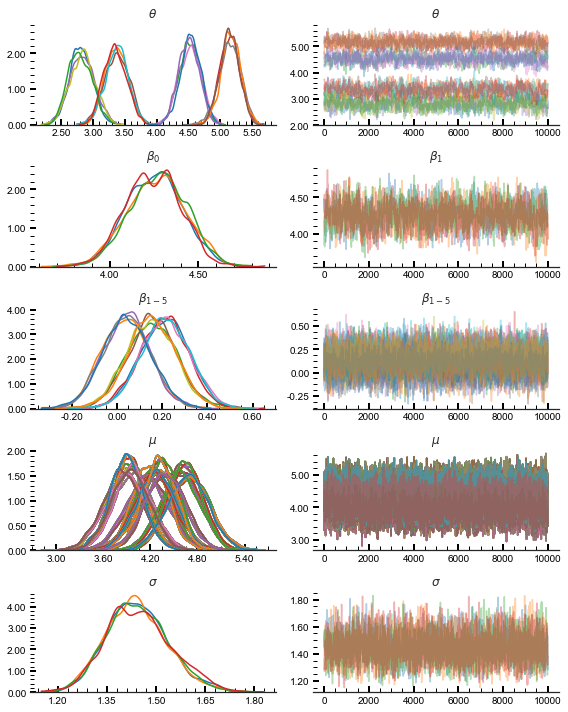

In [48]:
burned_trace = trace4 # pymc3.1 discards the first 500 samples
# pm.traceplot(burned_trace);

NRows = 5  # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(8, 10)
# fig, axs = sb.plt.subplots(5, 2) #### change on changing parameters
# fig.set_size_inches(12, 12)
pm.plots.traceplot(
    trace=burned_trace,
    #     varnames=['theta_missing', 'zbeta0', 'zbeta', 'mu', 'zsigma'],
    #     lines={
    #         'b0': (burned_trace['b0']).mean(),
    #         'b1': (burned_trace['b1']).mean(),
    #         'b2': (burned_trace['b2']).mean(),
    #         'b3': (burned_trace['b3']).mean(),
    #         'b4': (burned_trace['b4']).mean(),
    #     }
    ax=axs)
axs[0, 0].set_title(r"$\theta$")
axs[0, 1].set_title(r"$\theta$")
axs[1, 0].set_title(r"$\beta_0$")
axs[1, 1].set_title(r"$\beta_1$")
axs[2, 0].set_title(r"$\beta_{1-5}$")
axs[2, 1].set_title(r"$\beta_{1-5}$")
axs[3, 0].set_title(r"$\mu$")
axs[3, 1].set_title(r"$\mu$")
axs[4, 0].set_title(r"$\sigma$")
axs[4, 1].set_title(r"$\sigma$")
axs[1, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[3, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[4, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("")  # no individual labels
        z.set_ylabel("")
        if j==0:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(
            direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(
            direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()
        
sb.despine(fig=fig, left=True)
fig.tight_layout()
fig.savefig("posterior plots, color, not pooled.pdf")

In [49]:
pm.summary(trace4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta_missing__0,2.821078,0.189145,0.008089,2.461268,3.198816,482.0,1.003095
theta_missing__1,3.366133,0.181527,0.007785,3.005687,3.700985,465.0,1.003345
theta_missing__2,4.520100,0.165763,0.006827,4.206344,4.843725,524.0,1.002686
theta_missing__3,5.152939,0.159192,0.006098,4.834503,5.459481,629.0,1.002004
zbeta0,4.256721,0.160774,0.005723,3.963445,4.583631,680.0,1.003184
zbeta__0,0.208920,0.107656,0.001935,0.004251,0.421229,3544.0,1.000488
zbeta__1,0.040457,0.105455,0.001591,-0.168688,0.244608,3848.0,1.000308
zbeta__2,0.151107,0.109593,0.001849,-0.066324,0.362434,3232.0,1.000234
mu__0,4.585269,0.253262,0.006368,4.089879,5.073903,1398.0,1.000959
mu__1,4.585269,0.253262,0.006368,4.089879,5.073903,1398.0,1.000959


In [91]:
axs.shape

(2,)

# Hierarchical regression on Individuals within groups (Effect of Color)

In [20]:
# Using dtype 'category' for Y
df_color_H = pd.read_csv(
    'data/color_data_0330_ID.csv',
    dtype={
        'ID': 'int',
        'y': 'int',
        'color': 'int',
        'color_position': 'int',
        'cond': 'int'
    })

df_color_H['y'] = df_color_H['y'] + 4

y_cat = (df_color_H['y']).astype('category')  # in range 1-7
nYlevels = y_cat.nunique()

df_color_H.columns = ['Subj', 'color', 'location', 'condition', 'y']
df_color_H.Subj = df_color_H.Subj.astype('category')
df_color_H.Subj = df_color_H.Subj.cat.as_ordered()
df_color_H.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 5 columns):
Subj         189 non-null category
color        189 non-null int64
location     189 non-null int64
condition    189 non-null int64
y            189 non-null int64
dtypes: category(1), int64(4)
memory usage: 9.2 KB


### getting the number of individuals

In [21]:
subj_idx = df_color_H.Subj.cat.codes.as_matrix() #forms the index
subj_codes = df_color_H.Subj.cat.categories
n_subj = len(subj_codes)

print('Number of groups: {}'.format(n_subj))

Number of groups: 63


In [22]:
pr_test_val = df_color_H.groupby('y').size()/df_color_H.shape[0]
pr_test_val

y
1    0.026455
2    0.137566
3    0.105820
4    0.301587
5    0.158730
6    0.211640
7    0.058201
dtype: float64

### normalization

In [23]:
# predictors
sd_color = df_color_H.color.std()
mean_color = df_color_H.color.mean()
zcolor = (df_color_H.color - mean_color)/sd_color

sd_location = df_color_H.location.std()
mean_location = df_color_H.location.mean()
zlocation = (df_color_H.location - mean_location)/sd_location

sd_condition = df_color_H.condition.std()
mean_condition = df_color_H.condition.mean()
zcondition = (df_color_H.condition - mean_condition)/sd_condition


# response
sd_y = df_color_H.y.std()
mean_y = df_color_H.y.mean()
zy = (df_color_H.y - mean_y)/sd_y

# number of levels

nYlevels4 = y_cat.nunique()

thresh = [k + 0.5
           for k in range(1, nYlevels4)]  # fixing the boundaries in our case
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))


# initial probabilities 
pr_test_val = df_color_H.groupby('y').size()/df_color_H.shape[0]

thresh:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs:	[1.5 -- -- -- -- 6.5]


In [24]:
nYlevels4

7

### Model

$$\mu_{i,j} = \beta_{0,j} + \sum_{k=1}^3 \beta_{k,j} x_{k, j} $$

In [25]:
# helps compute the cdf


@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):

    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out


with pm.Model() as h_ordinal_model:

    # common thresholds for the metric space model
    # that is, everyone shares the thresholds

    theta = pm.Normal(
        'theta',
        mu=thresh,
        tau=np.repeat(1 / 2**2, len(thresh)),
        shape=len(thresh),
        observed=thresh_obs,
        testval=thresh)

    # priors on the means of the normal prior for \beta
    mu0 = pm.Normal('mu0', mu=(1 + nYlevels4) / 2, tau=1 / nYlevels4**2)
    mu1 = pm.Normal('mu1', mu=0, tau=1 / nYlevels4**2)
    mu2 = pm.Normal('mu2', mu=0, tau=1 / nYlevels4**2)
    mu3 = pm.Normal('mu3', mu=0, tau=1 / nYlevels4**2)

    # priors on the standard deviation of the normal prior for \beta
    sigma0 = pm.Uniform('sigma0', 10**-3, nYlevels4**2)
    sigma1 = pm.Uniform('sigma1', 10**-3, nYlevels4**2)
    sigma2 = pm.Uniform('sigma2', 10**-3, nYlevels4**2)
    sigma3 = pm.Uniform('sigma3', 10**-3, nYlevels4**2)

    # creating a beta per subject
       
#     beta0_s = pm.Cauchy('beta0_s', alpha=(1 + nYlevels4) / 2, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[0])
#     beta1_s = pm.Cauchy('beta1_s', alpha=0.0, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[1])
#     beta2_s = pm.Cauchy('beta2_s', alpha=0.0, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[2])
#     beta3_s = pm.Cauchy('beta3_s', alpha=0.0, beta=nYlevels4**2, shape=n_subj, testval=beta_test_val[3])
    
    beta0_s = pm.Normal('beta0_s', mu=mu0, sd=sigma0, shape=n_subj, testval=beta_test_val[0])
    beta1_s = pm.Normal('beta1_s', mu=mu1, sd=sigma1, shape=n_subj, testval=beta_test_val[1])
    beta2_s = pm.Normal('beta2_s', mu=mu2, sd=sigma2, shape=n_subj, testval=beta_test_val[2])
    beta3_s = pm.Normal('beta3_s', mu=mu3, sd=sigma3, shape=n_subj, testval=beta_test_val[3])

    # computing the probability of observing the data
    # zsigma is the standard deviation of the underlying normal distribution


    mu = pm.Deterministic('mu', beta0_s[df_color_H.Subj.cat.codes] +
                          beta1_s[df_color_H.Subj.cat.codes] * zcolor +
                          beta2_s[df_color_H.Subj.cat.codes] * zlocation +
                          beta3_s[df_color_H.Subj.cat.codes] * zcondition)

    zsigma = pm.Uniform('zsigma', nYlevels4 / 1000.0, nYlevels4 * 10.0, testval=1.5)
#     zsigma = pm.HalfCauchy('zsigma', beta=nYlevels4, testval=1.5)
    pr = outcome_probabilities(theta, mu, zsigma)

    y = pm.Categorical('Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [26]:
with h_ordinal_model:
    step1 = pm.Metropolis()
    h_color_trace = pm.sample(10000, step=step1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [zsigma_log__]
>Metropolis: [beta3_s]
>Metropolis: [beta2_s]
>Metropolis: [beta1_s]
>Metropolis: [beta0_s]
>Metropolis: [theta_missing]
100%|██████████| 10500/10500 [04:40<00:00, 37.50it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [43]:
pm.diagnostics.gelman_rubin(mtrace=h_color_trace)

{'theta_missing': array([1.11198491, 1.13148701, 1.10512586, 1.06023884]),
 'mu0': 1.072595916553482,
 'mu1': 1.0384041754354705,
 'mu2': 1.1448919874988355,
 'mu3': 1.1150129580843615,
 'beta0_s': array([1.00489551, 1.00134451, 1.01472127, 1.04643238, 1.08434906,
        1.00732192, 1.02978614, 1.00597922, 1.03890809, 1.03783029,
        1.00057019, 1.02658428, 1.012127  , 1.01377203, 1.02386158,
        1.00369054, 1.02368865, 1.00521681, 1.0018138 , 1.01091496,
        1.07991535, 1.03165286, 1.00043738, 1.0100724 , 1.00764482,
        1.00148355, 1.07881233, 1.02098734, 1.010374  , 1.01865306,
        1.00053148, 1.01862525, 1.00334159, 1.02120021, 1.00084047,
        1.01372394, 1.01694249, 1.05798678, 1.11725052, 1.00254578,
        1.00436831, 1.01687669, 1.01395404, 1.00420369, 1.05901727,
        1.04172105, 1.00774999, 1.01564309, 1.00990252, 1.01368911,
        1.00290346, 1.05827113, 1.09163957, 1.05312785, 1.02123242,
        1.13162749, 1.00272663, 1.04187806, 1.12578736,

In [44]:
pm.diagnostics.effective_n(mtrace=h_color_trace)

{'theta_missing': array([ 6.,  5.,  8., 18.]),
 'mu0': 5.0,
 'mu1': 19.0,
 'mu2': 7.0,
 'mu3': 11.0,
 'beta0_s': array([13., 20.,  8.,  6.,  5.,  6., 10., 72.,  8.,  8.,  8., 11.,  9.,
        11.,  8.,  7., 14.,  7., 10.,  6.,  6.,  8., 14., 14.,  8.,  9.,
         6., 11., 10., 22., 10.,  8., 10.,  9.,  6., 58.,  8.,  8.,  4.,
        28., 10., 10., 12., 18.,  8.,  9.,  8., 52.,  9.,  8.,  6.,  5.,
         5., 39., 35.,  5., 12.,  9.,  5.,  9., 16., 10., 12.]),
 'beta1_s': array([ 53.,  16.,  44.,  12.,  58.,  16.,  11.,  67.,  65.,  12.,  54.,
         45.,   9., 115., 101.,  58.,  22.,   8.,  22.,  85.,  75.,  70.,
         34.,  25.,  99.,  35.,  25.,  59.,  18.,  11.,  75.,  12.,  12.,
         20.,  46.,  22.,  12.,  16.,  86.,  28.,  37.,  20.,  27.,  12.,
         16.,  31.,  40.,  40.,  59.,   9.,  16.,  17.,   9.,  45.,  41.,
         20.,  21.,  32.,  11.,  17.,  24.,  24.,  35.]),
 'beta2_s': array([ 9., 10.,  9., 58.,  6.,  9., 55., 13., 53., 42., 11., 12.,  8.,
        

In [27]:
pm.stats.summary(h_color_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta_missing__0,2.728487,0.202488,0.014180,2.349678,3.120729,27.0,1.009836
theta_missing__1,3.290211,0.195773,0.014066,2.917406,3.655004,28.0,1.009161
theta_missing__2,4.509358,0.172191,0.011775,4.167357,4.816324,44.0,1.014404
theta_missing__3,5.169935,0.166899,0.010725,4.833633,5.476341,59.0,1.019356
mu0,4.230972,0.205561,0.018070,3.848962,4.606637,18.0,1.044459
mu1,0.182718,0.161470,0.013315,-0.123403,0.532309,10.0,1.150174
mu2,0.045201,0.123398,0.009747,-0.177153,0.289581,19.0,1.096445
mu3,0.111551,0.176058,0.015330,-0.232673,0.455937,17.0,1.029645
beta0_s__0,4.118244,0.557880,0.040302,3.013179,5.256197,26.0,1.005740
beta0_s__1,4.400002,0.596763,0.045711,3.137169,5.583525,28.0,1.015564


### pooled plots

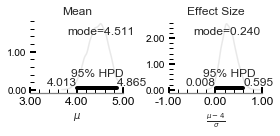

In [28]:

sigma = h_color_trace['zsigma']
mu = h_color_trace['mu']
mu_mean = np.mean(mu, axis=1)

# compute the effect size
center = 4
n_m = (mu_mean - center) / sigma

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(4, 2)

pm.plot_posterior(
    mu_mean,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    text_size=12)
pm.plot_posterior(
    n_m,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    text_size=12)

axs2[0].set_title(r"Mean")
axs2[0].set_xlim([3,5])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
axs2[1].set_xlim([-1,1])
axs2[1].set_xlabel(r'$\frac{\mu-4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("mean_effect_color_pooled.pdf")

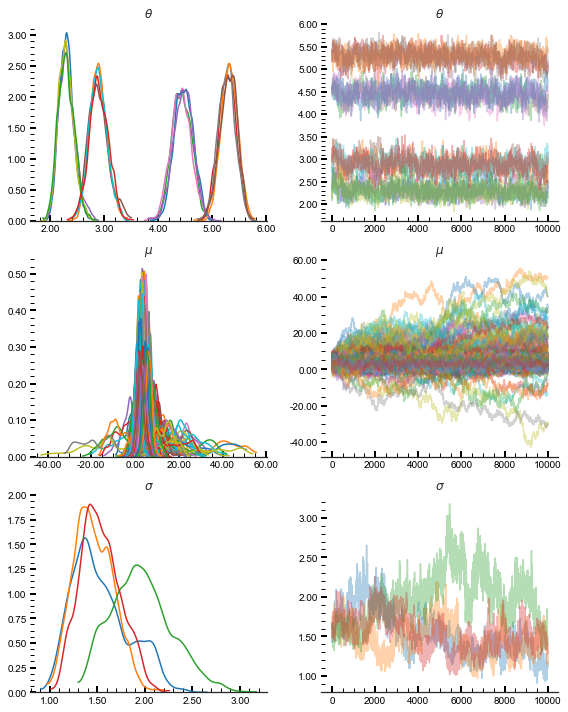

In [27]:
burned_trace = h_color_trace # pymc3.1 discards the first 500 samples
# pm.traceplot(burned_trace);

NRows = 3  # change based on the number of parameters
NCols = 2
sb.set_style("white")
fig, axs = sb.mpl.pyplot.subplots(NRows,
                                  NCols)  #### change on changing parameters
fig.set_size_inches(8, 10)
# fig, axs = sb.plt.subplots(5, 2) #### change on changing parameters
# fig.set_size_inches(12, 12)
pm.plots.traceplot(
    trace=burned_trace,
    varnames=['theta_missing', 'mu', 'zsigma'],
    ax=axs)
axs[0, 0].set_title(r"$\theta$")
axs[0, 1].set_title(r"$\theta$")
axs[1, 0].set_title(r"$\mu$")
axs[1, 1].set_title(r"$\mu$")
axs[2, 0].set_title(r"$\sigma$")
axs[2, 1].set_title(r"$\sigma$")
# axs[1, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
# axs[3, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[4, 0].xaxis.set_major_locator(plt.MaxNLocator(6))
for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("")  # no individual labels
        z.set_ylabel("")
        if j==0:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            z.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(
            direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(
            direction='in', length=4, width=1, colors='k', which='minor')
        z.xaxis.set_ticks_position('bottom')
        z.yaxis.set_ticks_position('left')
        z.minorticks_on()
        
sb.despine(fig=fig, left=True)
fig.tight_layout()
fig.savefig("posterior plots, color, pooled.pdf")